In [1]:
import numpy as np
import random
import cv2
import PIL
import matplotlib.pyplot as plt

from copy import deepcopy

## 1 Extract Harris interest points

In [5]:
def get_points(img, threshold=0.1, coordinate=False):
    """
    Extract harris points of given image

    :param img: An image of type open cv
    :param threshold: Threshold of max value in found points
    :param coordinate: Return a tuple of (x, y) coordinates instead of mask
    :return: A matrix same size as input as a binary mask of points
    """
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)
    img_harris = cv2.cornerHarris(img_gray, 7, 3, 0.03)
    img_points = img_harris > threshold * img_harris.max()
    if coordinate:
        img_points = (img_points * 1).nonzero()
        return img_points
    return img_points


image1 = cv2.imread('../data/images/building1.jpg')
image2 = cv2.imread('../data/images/building2.jpg')

image1_points = get_points(image1, coordinate=True)
image2_points = get_points(image2, coordinate=True)

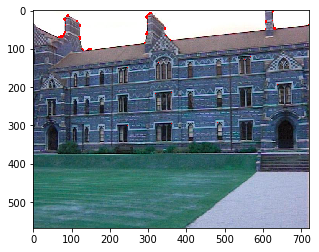

In [6]:
vis = deepcopy(image1)
vis[image1_points] = [255, 0, 0]
plt.imshow(vis, cmap='gray')

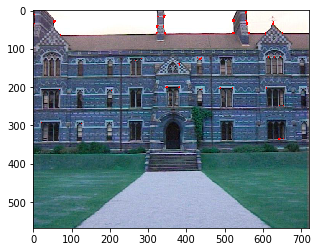

In [7]:
vis = deepcopy(image2)
vis[image2_points] = [255, 0, 0]
plt.imshow(vis, cmap='gray')

# 2 Preprocess points

In [8]:
def to_array(img_points):
    """
    Changes tuple of coordinates (list[x], list[y]) to a [len(x|y), 1, 2] numpy float32 array
    PS. convert type of points into 'cv2.goodFeaturesToTrack' convention.

    :param img_points: Coordinate of harris points in form of tuple
    :return: A 3D array of coordinates
    """
    assert isinstance(img_points, tuple)
    img_points_lk = np.zeros((len(img_points[0]), 1, 2), dtype=np.float32)
    img_points_lk[:, :, 0] = np.array(img_points[1]).reshape(-1, 1)
    img_points_lk[:, :, 1] = np.array(img_points[0]).reshape(-1, 1)
    return img_points_lk


def to_tuple(img_points):
    """
    Changes a [len(x|y), 1, 2] numpy float32 array coordinates to tuple of coordinates (list[x], list[y]) uint8
    PS. convert type of points into 'np.nonzero()' convention.
    :param img_points: A 3D array of coordinates
    :return: Coordinate of harris points in form of tuple
    """
    coor1 = [i[0, 0].astype(np.int) for i in img_points]
    coor2 = [i[0, 1].astype(np.int) for i in img_points]
    img_points_tuple = (coor2, coor1)
    return img_points_tuple


image1_points_lk = to_array(image1_points)
image2_points_lk = to_array(image2_points)

In [9]:
def lucas_kanade_tracker(img1, img2, img1_points_lk, img2_points_lk, lk_params=None, threshold=1.0):
    if lk_params is None:
        lk_params = dict(winSize=(19, 19), maxLevel=2,
                         criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    img2_points_lk, _, _ = cv2.calcOpticalFlowPyrLK(cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY),
                                                    cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY),
                                                    img1_points_lk, None, **lk_params)
    img1_points_lk_recalc, _, _ = cv2.calcOpticalFlowPyrLK(cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY),
                                                           cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY),
                                                           img2_points_lk, None, **lk_params)
    distance = abs(img1_points_lk - img1_points_lk_recalc).reshape(-1, 2).max(-1)
    status = distance < threshold

    # preserve good points
    img1_good_points = img1_points_lk[status == 1]
    img2_good_points = img2_points_lk[status == 1]
    return img1_good_points, img2_good_points


image1_good_points, image2_good_points = lucas_kanade_tracker(image1, image2, image1_points_lk, image2_points_lk)

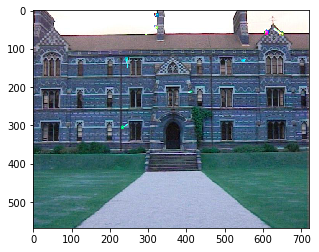

In [10]:
color = np.random.randint(0, 255, (len(image2_good_points), 3))
mask = np.zeros_like(image1)
frame = image2.copy()
for i, (i2, i1) in enumerate(zip(image2_good_points, image1_good_points)):
    a, b = i2.ravel()
    c, d = i1.ravel()
    mask = cv2.line(mask, (a, b), (c, d), color[i].tolist(), 2)
    frame = cv2.circle(frame, (a, b), 5, color[i].tolist(), -1)

vis = cv2.add(frame, mask)
plt.imshow(vis, cmap='gray')

# 3 Homogrphy

In [11]:
def homography(points1, points1_indices, points2, points2_indices, num_points=4, min_num_points=4):
    """
    Computes homography matrix for given two sets of points

    :param points1: First point set
    :param points1_indices: First point set indices
    :param points2: Second point set
    :param points2_indices: Second Point set indices
    :param num_points: Number of points to use for calculating homography
    :param min_num_points: Minimum number of points required (Degree of freedom)
    :return: A 3x3 normalized homography matrix
    """
    assert num_points >= min_num_points

    # build A matrix
    a_matrix = np.zeros((num_points * 2, 9))
    idx = 0
    for i, j in zip(points1_indices, points2_indices):
        a_matrix[idx, :] = np.array([-points1[i, 0, 0], -points1[i, 0, 1], -1,
                                     0, 0, 0,
                                     points2[j, 0, 0] * points1[i, 0, 0],
                                     points2[j, 0, 0] * points1[i, 0, 1],
                                     points2[j, 0, 0]])
        idx += 1
        a_matrix[idx, :] = np.array([0, 0, 0,
                                     -points1[i, 0, 0], -points1[i, 0, 1], -1,
                                     points2[j, 0, 1] * points1[i, 0, 0],
                                     points2[j, 0, 1] * points1[i, 0, 1],
                                     points2[j, 0, 1]])
        idx += 1

    u, s, v = np.linalg.svd(a_matrix)
    h_unnormalized = v[8].reshape(3, 3)
    h = (1 / h_unnormalized.flatten()[8]) * h_unnormalized

    # eig = np.linalg.eig(a_matrix.T.dot(a_matrix))
    # # smallest_idx = eig[0].argmin()
    # h_ = eig[1][-1].reshape(3, 3)
    # h = (1 / h_.flatten()[8]) * h_
    return h


MIN_NUM_POINTS = 4
points1_indices = random.sample(list(range(len(image1_good_points))), MIN_NUM_POINTS)
h_matrix = homography(image1_good_points, points1_indices, image2_good_points, points1_indices)

# 4 RANSAC

In [12]:
def error(match, homography):
    """
    Computes the error (L2 norm) between predicted position of point set 2 using given homography matrix

    :param match: A dictionary containing 'p1' as point 1 and 'p2' as point 2
    :param homography: A 3x3 homography matrix
    :return: A float number as euclidean distance between predicted point and it's original value
    """
    p1 = match['p1']
    p2 = match['p2']
    # to cart
    point1 = np.array([p1[0], p1[1], 1])
    point2_pred = np.dot(homography, point1.T)
    # to homo
    point2_pred = point2_pred / point2_pred[-1]
    point2 = np.array([p2[0], p2[1], 1])
    return np.sqrt(np.sum((point2 - point2_pred) ** 2))


# RANSAC
def ransac(points1, points2, threshold=10.0, n_iterations=10000, early_stop=None, min_num_points=4):
    max_inlier = 0
    best_h = np.zeros((3, 3))

    if early_stop is not None:
        raise NotImplementedError()

    for i in range(n_iterations):
        points1_indices = random.sample(list(range(len(points1))), min_num_points)
        h_matrix = homography(points1, points1_indices, points2, points1_indices)

        inlier = 0
        for j in range(len(image1_good_points)):
            match = {'p1': image1_good_points[j, 0],
                     'p2': image2_good_points[j, 0]}
            e = error(match, h_matrix)
            if e <= threshold:
                inlier += 1

        if inlier > max_inlier:
            max_inlier = inlier
            best_h = h_matrix
    return best_h, max_inlier


In [13]:
best_homography, max_inliers = ransac(image1_good_points, image2_good_points, n_iterations=50000, threshold=10.)
print('Max inliers: ', max_inliers)
z1 = image1_good_points[0]
z1 = np.array([z1[0, 0], z1[0, 1], 1])
z2 = best_homography.dot(z1.T)
z2 = z2/z2[-1]
print(z2[:-1], image2_good_points[0])

Max inliers:  32
[ 320.49807656   12.30184933] [[ 320.49807739   12.30184937]]


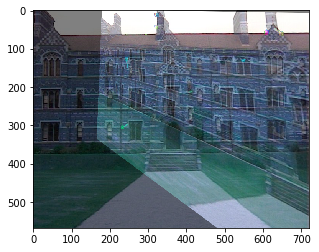

In [14]:
h, w = image2.shape[:2]
overlay = cv2.warpPerspective(image1, best_homography, (w, h))
vis = cv2.addWeighted(vis, 0.5, overlay, 0.5, 0.0)
plt.imshow(vis)